In [1]:
import pandas as pd
import numpy as np
import atoti as tt

Welcome to atoti 0.7.1!

By using this community edition, you agree with the license available at https://docs.atoti.io/latest/eula.html.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

atoti collects telemetry data, which is used to help understand how to improve the product.
If you don't wish to send usage data, set the ATOTI_DISABLE_TELEMETRY environment variable to True.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


In [2]:
# !pip install graphviz

## Dataset

In [3]:
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
studentAssessment = pd.read_csv('studentAssessment.csv')
studentInfo = pd.read_csv('studentInfo.csv')
studentReg = pd.read_csv('studentRegistration.csv')
studentVle =pd.read_csv('studentVle.csv')
vle = pd.read_csv('vle.csv')

## Data Cleaning

#### Null Value Check

##### Student Vle

In [4]:
studentVle.isnull().sum()

code_module          0
code_presentation    0
id_student           0
id_site              0
date                 0
sum_click            0
dtype: int64

##### Vle

In [5]:
vle.isnull().sum()

id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64

In [6]:
vle.shape

(6364, 6)

Disini, week_from dan week_to dapat di drop karena hampir sebagian besar bernilai null dan tidak memberikan insight yang berarti

In [7]:
vle = vle.drop(['week_from','week_to'],axis=1)

In [8]:
vle.isnull().sum()

id_site              0
code_module          0
code_presentation    0
activity_type        0
dtype: int64

##### Student Info

In [9]:
studentInfo.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

imd_band merupakan index tingkat kesengsaraan pada suatu daerah tertentu pada saat siswa melakukan pembelajaran. Di sini, nilai null dapat dihiraukan karena pada kasus yang kita gunakan imd_band tidak digunakan untuk prediksi ataupun pembelajaran pada machine learning, melainkan pencarian informasi/insight

##### Student Assessment

In [10]:
studentAssessment.isnull().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

Null value pada score dapat berarti siswa tidak mengumpulkan hasil tes yang dikerjakan sehingga tidak tersimpan pada sistem. Untuk itu, dapat kita ini dengan nilai 0, yang berarti ketikda siswa tidak mengumpulkan pekerjaannya, maka akan otomatis dinilai nol

In [11]:
studentAssessment['score'] = studentAssessment['score'].fillna(0)

##### Assessment

In [12]:
assessments.isnull().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

Null value pada date dapat dihiraukan 

#### Classification Column for Roll-Up Aggregation

##### Classification based on imd_band (Depravation Index)

In [13]:
studentInfo['imd_band'].unique()

array(['90-100%', '20-30%', '30-40%', '50-60%', '80-90%', '70-80%', nan,
       '60-70%', '40-50%', '10-20', '0-10%'], dtype=object)

In [14]:
def GetDepravation(percentage):
    if(percentage == '0-10%' or percentage == '10-20' or percentage == '30-40%'):
        return "Most Deprived"
    elif(percentage == '90-100%' or percentage == '80-90%' or percentage == '70-80%'):
        return "Least Deprived"
    else:
        return "Normal Deprived"

studentInfo["deprivation"] = np.nan
studentInfo["deprivation"] = studentInfo.apply(lambda x : GetDepravation(x['imd_band']), axis=1)

In [15]:
studentInfo.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,deprivation
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,Least Deprived
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,Normal Deprived
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,Most Deprived
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,Normal Deprived
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,Normal Deprived


##### Classification based on student score

Klasifikasi pada score yang didapat oleh siswa dapat dikelompokkan menjadi nilai A, B, C, D, dan E untuk range score tertentu.

In [16]:
studentAssessment['score'].unique()

array([ 78.,  70.,  72.,  69.,  79.,  71.,  68.,  73.,  67.,  83.,  66.,
        59.,  82.,  60.,  75.,  74.,  62.,  63.,  84.,  80.,  76.,  85.,
        57.,  81.,  87.,  77.,  45.,  65.,  61.,  52.,  54.,  51.,  88.,
        58.,  64.,  55.,  38.,  91.,  47.,  89.,  36.,  86.,  49.,  53.,
        39.,   0.,  90.,  50.,  56.,  30.,  11.,  40.,  94.,  48.,  46.,
        25.,  34.,  42.,  18.,  37.,  28.,  33.,  95.,  35.,  44.,  41.,
        15.,  43.,  93.,  32.,  92.,  98.,  24.,  19.,  27.,  29.,  20.,
        97.,  23.,  99., 100.,  10.,   5.,  13.,  26.,  22.,   8.,  12.,
        16.,   9.,  96.,  14.,  21.,  17.,  31.,   6.,   1.,   7.,   4.,
         2.,   3.])

Grading matrix :
- above 80 = A
- 70 to 85 = B
- 55 to 70 = C
- 40 to 55 = D
- below 40 = E (Fail)

In [17]:
pd.set_option('mode.chained_assignment', None)

studentAssessment["score_cat"] = np.nan
studentAssessment["score_cat"] = "E"

for i in range(40, 56) :
    studentAssessment["score_cat"][studentAssessment["score"] == i] = "D"
    
for i in range(56, 71) :
    studentAssessment["score_cat"][studentAssessment["score"] == i] = "C"

for i in range(71, 86) :
    studentAssessment["score_cat"][studentAssessment["score"] == i] = "B"
    
for i in range(86, 101) :
    studentAssessment["score_cat"][studentAssessment["score"] == i] = "A"


studentAssessment.head(5)

,id_assessment,id_student,date_submitted,is_banked,score,score_cat
0,1752,11391,18,0,78.0,B
1,1752,28400,22,0,70.0,C
2,1752,31604,17,0,72.0,B
3,1752,32885,26,0,69.0,C
4,1752,38053,19,0,79.0,B


## Cube and Data Exploration

### ID conversion to string Data type

#### Pengubahan tipe data pada kolom ID pada tabel yang digunakan berguna agar tidak dilakukan aggregasi oleh atoti

##### Student Vle Table

In [18]:
studentVle['id_student'] = studentVle['id_student'].astype('string')

In [19]:
studentVle['id_site'] = studentVle['id_site'].astype('string') 

##### VLE Table

In [20]:
vle['id_site']  = vle['id_site'].astype('string')

##### Student Assessment Table

In [21]:
studentAssessment['id_student'] = studentAssessment['id_student'].astype('string')
studentAssessment['id_assessment'] = studentAssessment['id_assessment'].astype('string')

##### Student Info Table

In [22]:
studentInfo['id_student'] = studentInfo['id_student'].astype('string')

##### Assessment

In [23]:
assessments['id_assessment'] = assessments['id_assessment'].astype('string')

### Data exploration

#### Kita ingin mengetahui bagaimana highest_education mempengaruhi faktor-faktor yang lain

In [24]:
session = tt.Session()

In [25]:
studentInfoSession = session.read_pandas(studentInfo, table_name = 'Studentinfo')

In [26]:
studentInfoC = session.create_cube(studentInfoSession)

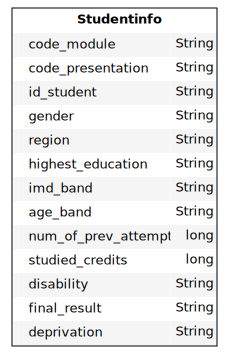

In [27]:
studentInfoC.schema

Melihat distribusi siswa pada tiap jenjang 

In [28]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Melihat jumah final result dari tiap jenjang :

In [29]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Dapat dilihat bahwa untuk A level or equivalent didominasi oleh hasil pass, sementara untuk melihat pada No Formal dan Post Graduate 

In [30]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Dapat kita lihat untuk No Formal Quals memiliki jumlah Withdrawn yang lebih banyak daripada yg lainnya.

#### Exploratory on StudentVle, StudentInfo, and VLE table

In [31]:
studentVleS = session.read_pandas(studentVle, table_name='Studentvle')

In [32]:
vleS = session.read_pandas(vle, table_name='vle')

In [33]:
studentVleCube = session.create_cube(studentVleS)

In [34]:
studentVleS.join(vleS, mapping={'id_site': 'id_site'})

In [35]:
studentVleS.join(studentInfoSession, mapping={'id_student': 'id_student'})

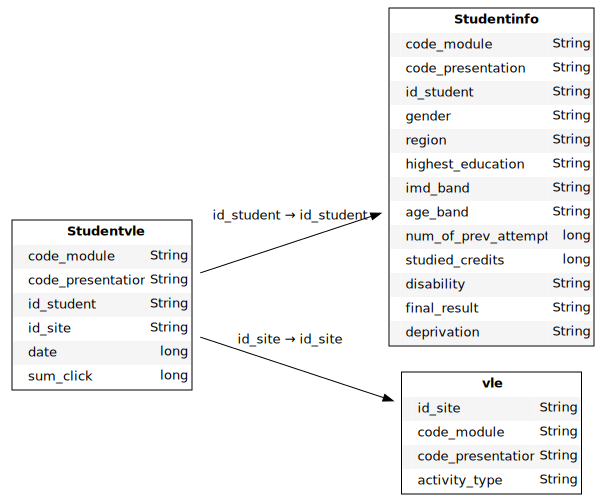

In [36]:
studentVleCube.schema

### Melihat pengaruh level education terhadap jumlah click dan aktivitas apa yang paling aktiv digunakan 

Melihat sebaran rerata click yang paling banyak dilakukan oleh siswa pada tiap tipe aktivitas

In [37]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Melakukan slicing untuk tipe aktivitas Forumng, Glossary, Homepage, dan Quiz

In [38]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Untuk forum, homepage, dan quiz ternyata memberikan rerata aktivitas click yang hampir sama untuk tiap level pendidikan, akan tetapi untuk glossary, semakin tinggi level pendidikan semakin banyak dia melakukan interaksi pada aktivitas tsb

#### Melakukan Dicing untuk hasil akhir fail dan pass

In [39]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Bisa kita lihat untuk rerata click untuk pada tipe aktivitas forumng, homepage, dan quiz di tiap jenjang pendidikan tidak mempengaruhi apakah siswa lulus atau gagal, akan tetapi terdapat perbedaan pada glossary dimana siswa yang memiliki hasil akhir lulus memiliki rerata jumlah click yang lebih tinggi dari pada siswa yang gagal

In [59]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Visualisasi Hierarki

#### Exploratory on Student Information, Student Assessment, dan Asssessment

In [40]:
studentAssessmentSession = session.read_pandas(studentAssessment, table_name='Studentassessment')

In [41]:
assessmentsSession = session.read_pandas(assessments, table_name = 'assessments')

In [42]:
studentAssessmentCube = session.create_cube(studentAssessmentSession)

In [43]:
studentAssessmentSession.join(assessmentsSession, mapping={'id_assessment':'id_assessment'})

In [44]:
studentAssessmentSession.join(studentInfoSession, mapping={'id_student':'id_student'})

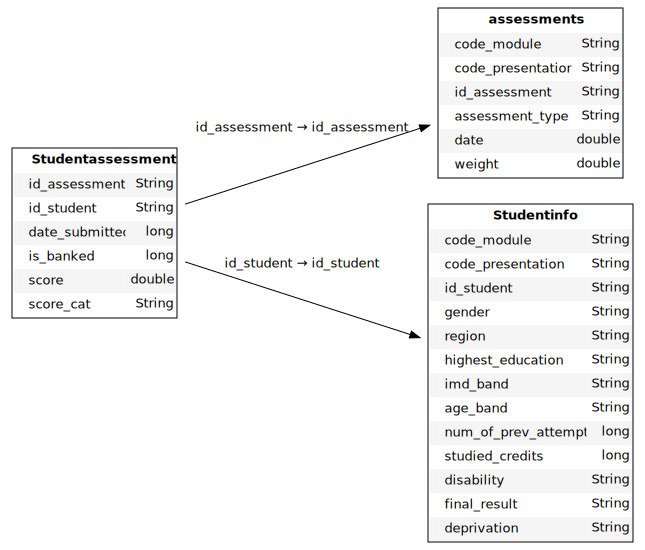

In [45]:
studentAssessmentCube.schema

#### Melihat sebaran nilai pada tiap jenjang

In [63]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Secara umum, sebaran nilai banyak tersebar untuk nilai A, B, dan C untuk jenjang A level or Equivalent, HE Qual, dan Lower than a level.

Melihat sebaran nilai lebih detail pada No Formal dan Post Grad :

In [62]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

No Formal memberikan distribusi normal sementara post grad memiliki kecenderungan sebaran pada nilai A.

#### Melihat apakah jenjang pendidikan berpengaruh pada skor rata-rata assessment

In [46]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Akan terlihat trend bahwa semakin tinggi jenjang pendidikan, maka semakin tinggi pula rerata nilai pada tugas

In [47]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

(TMA = Tutor-marked assignment, CMA= computer-marked assignment)

Disini kita juga dapat melihat trend kenaikan rata-rata nilia pada tiap tipe assessment seiring tingginya level pendidikan, dimana nilai exam hampir selalu lebih rendah dari pada nilai TMA dan CMA.

#### Melihat bagaimana tingkat kesejahteraan terhadap rerata nilai untuk setiap level pendidikan

In [48]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

least deprived = sejahtera

Ternyata, untuk tiap klasifikasi kesejahteraan, post graduate tetap memimliki rerata nilai yang paling bagus diantara level pendidikan yang lainnya, diikuti oleh HE, A lvl Equivalent, lower than a level, dan No formal Quals. Dapat kita lihat juga untuk jenjang level pendidikan yang tidak memiliki pendidikan formal memberikan rerata nilai yang sama dengan HE Quals pada kasus tingkat yang paling sejahtera.

Kemudian, dapat kita lihat juga bahwa terjadi trend dimana untuk siswa yang paling sejahtera, akan memiliki rerata nilai yang paling baik, diikuti oleh normal, dan tidak sejahtera. 

#### Melihat bagaimana sebaran rerata nilai untuk tiap level pendidikan terhadap kesejahteraan dan Gender

In [49]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Menunjukkan bahwa terdapat kecendrungan bahwa nilai rata-rata perempuan lebih baik daripada laki-laki untuk trend kenaikan rerata nilai yang sama

### Melihat visualisasi dalam hierarki

In [50]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Kesimpulan

1. Perbanyaklah membaca glossary untuk meningkatkan kemungkinan kelulusan.
2. Pilihlah daerah yang memiliki tingkat kesejahteraan yang tinggi saat melakukan pembelajaran.
3. Timbalah ilmu setinggi mungkin karena semakin tinggi jenjang pendidikan akan meningkatkan kecerdasan yang semakin tinggi.